In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
#importing the Convolution Layer 2d 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
import warnings
warnings.filterswarnings=('ignore')

In [2]:
df=tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\Nalamati Yasaswini\Documents\DL Project\DATASET",seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 3758 files belonging to 9 classes.


In [3]:
classes=df.class_names
classes

['Brown_spot',
 'Healthy',
 'Hispa-20230613T073455Z-001',
 'Narrow_brown_spot-20230613T073510Z-001',
 'Shath Blight-20230613T073514Z-001',
 'Tungro-20230613T073535Z-001',
 'bacterial_leaf_blight',
 'leaf_blast-20230613T073503Z-001',
 'leaf_scald-20230613T073507Z-001']

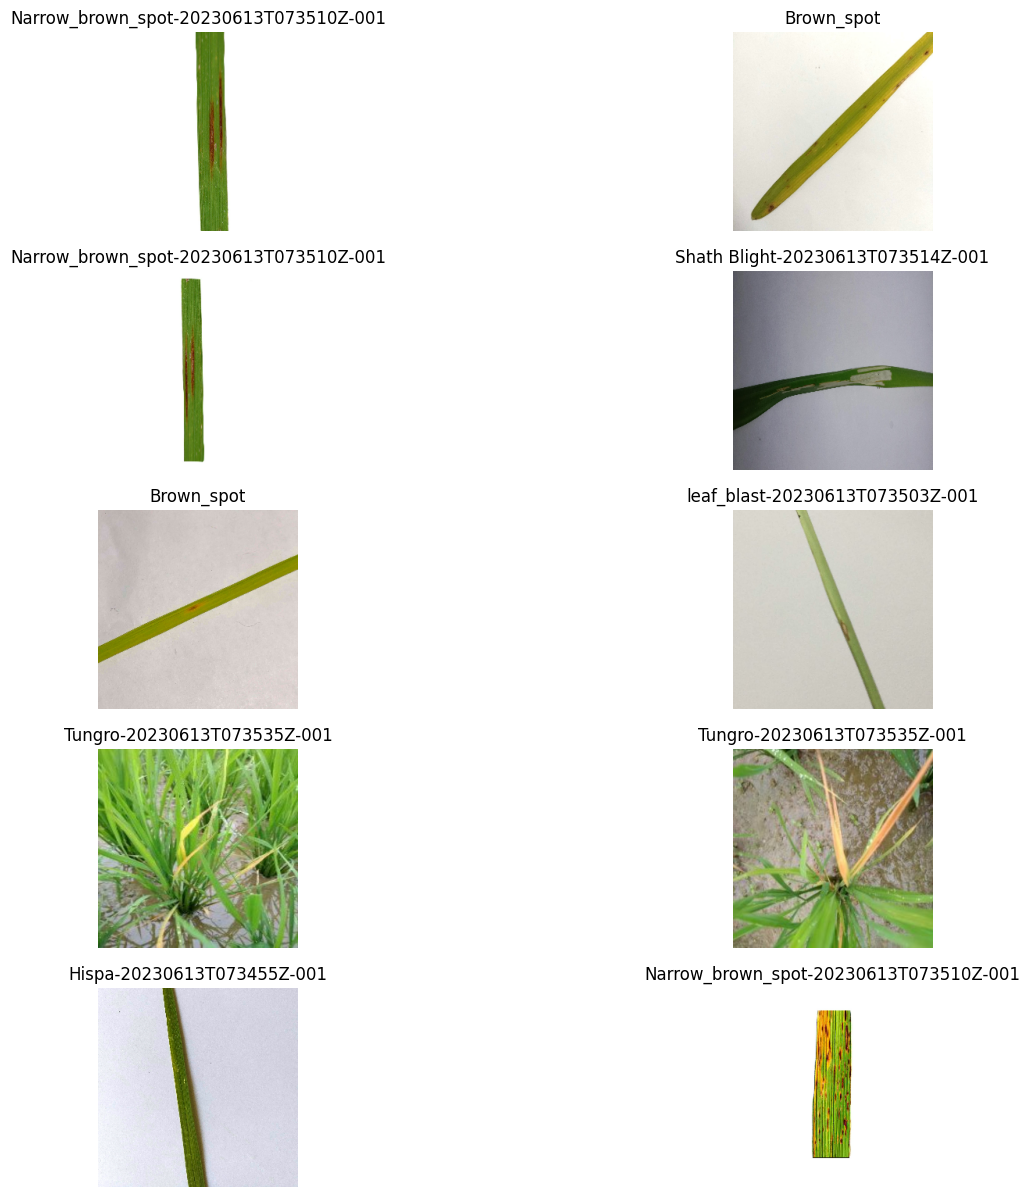

In [4]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in df.take(7):
    for i in range(10):
        ax = plt.subplot(5,2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [9]:
# rotating and flipping the images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
#inserting the augmented data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import models
input_shape = (32, 256, 256, 3)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [12]:
#checking the summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [13]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
94/94 [==============================] - 207s 2s/step - loss: 1.6889 - accuracy: 0.3769 - val_loss: 1.3322 - val_accuracy: 0.5909
Epoch 2/50
94/94 [==============================] - 173s 2s/step - loss: 1.1968 - accuracy: 0.5488 - val_loss: 1.1218 - val_accuracy: 0.6023
Epoch 3/50
94/94 [==============================] - 171s 2s/step - loss: 0.9130 - accuracy: 0.6853 - val_loss: 0.8202 - val_accuracy: 0.7784
Epoch 4/50
94/94 [==============================] - 166s 2s/step - loss: 0.7062 - accuracy: 0.7411 - val_loss: 0.5598 - val_accuracy: 0.8011
Epoch 5/50
94/94 [==============================] - 170s 2s/step - loss: 0.5710 - accuracy: 0.7856 - val_loss: 0.5526 - val_accuracy: 0.8068
Epoch 6/50
94/94 [==============================] - 169s 2s/step - loss: 0.5908 - accuracy: 0.7766 - val_loss: 0.4995 - val_accuracy: 0.8324
Epoch 7/50
94/94 [==============================] - 222s 2s/step - loss: 0.4898 - accuracy: 0.8130 - val_loss: 0.4253 - val_accuracy: 0.8722
Epoch 8/50
94

In [15]:
train_scores = model.evaluate(train_ds)
test_scores = model.evaluate(test_ds)

13/13 [==============================] - 23s 257ms/step - loss: 0.2245 - accuracy: 0.9207


first image to predict
actual label: Tungro-20230613T073535Z-001
1/1 [==============================] - 1s 524ms/step
predicted label: bacterial_leaf_blight
first image to predict
actual label: Hispa-20230613T073455Z-001
1/1 [==============================] - 0s 255ms/step
predicted label: Shath Blight-20230613T073514Z-001


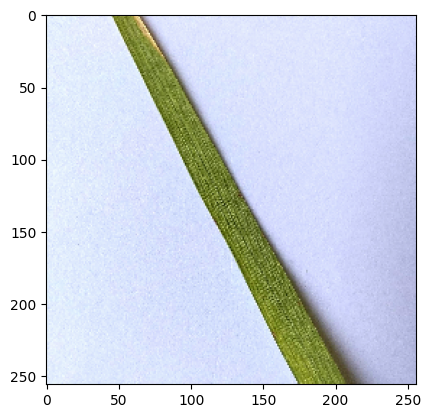

In [16]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):
    
    first_image = images_batch[19].numpy().astype('uint8')
    first_label = labels_batch[19].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


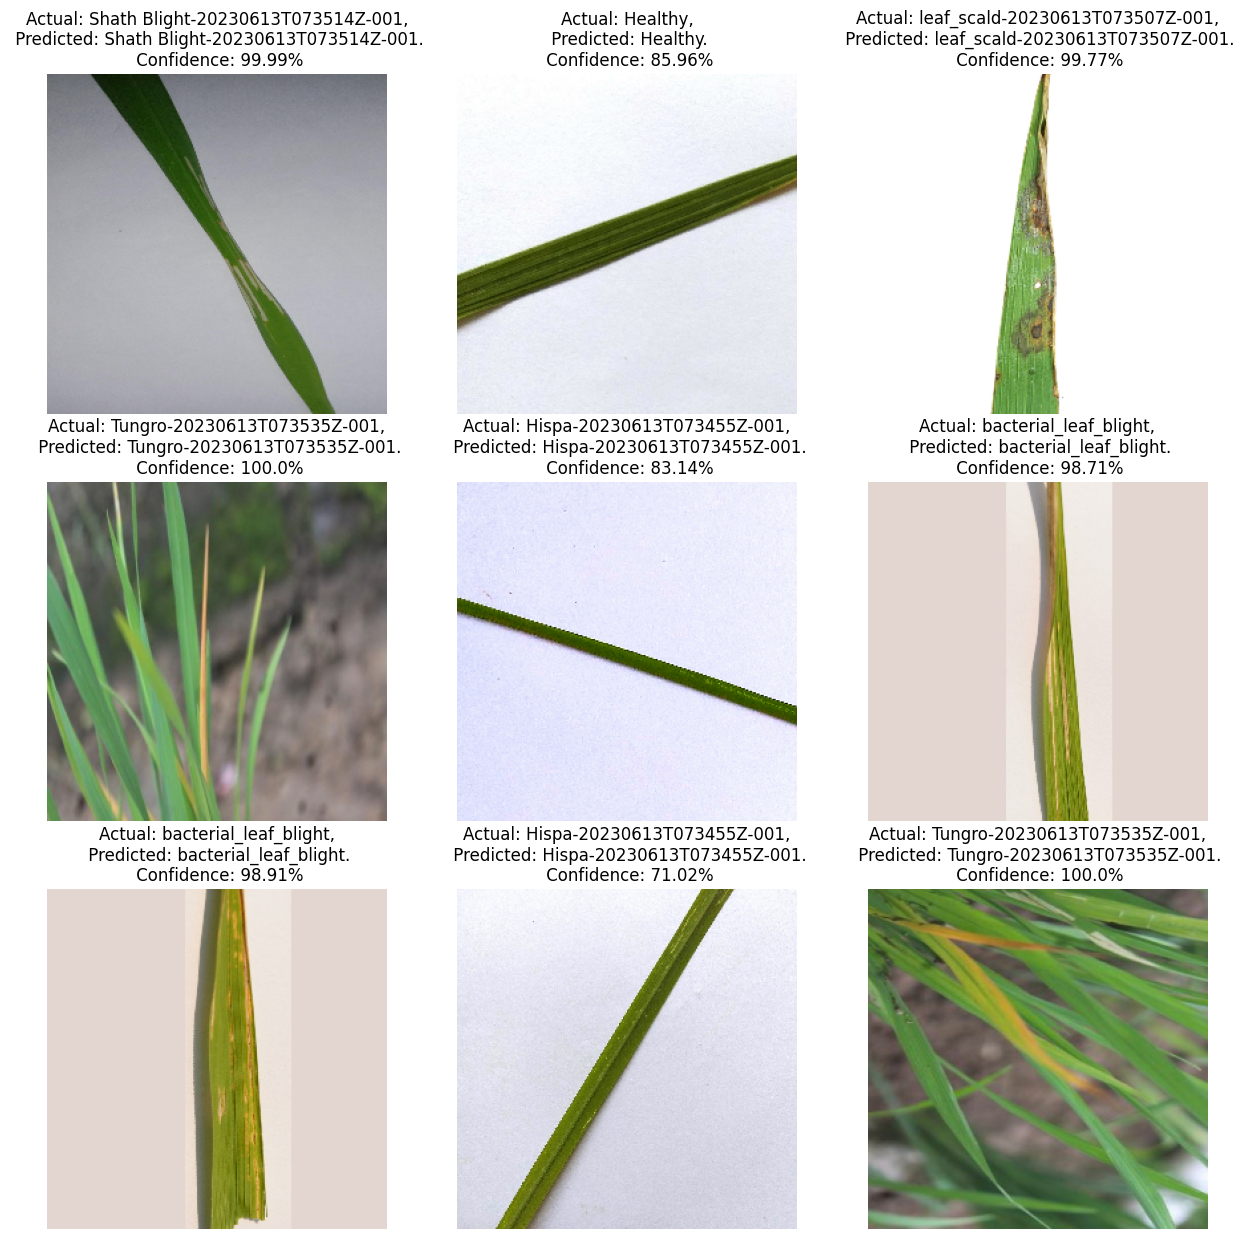

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")